# Targeted, Constrained Bayesian Optimization (Cu₃VS₄) — Polished Notebook

This notebook keeps the **same overall architecture** as your multi-objective BO code (GP models + acquisition + candidate pool scoring + visual diagnostics), but changes one key thing:

- **Size is treated as a *targeted probabilistic constraint*** ("hit the requested size")  
- Within that constraint, we **optimize**:
  - **lowest GSD** (minimize)
  - **highest squareness** (maximize)
  - while enforcing **cubic + phase pure (+ product)** feasibility

This gives you the tool you described:

> “I choose a size (10–30 nm) and it returns the optimal synthesis conditions for *that size*.”

---

## What you edit most often
- **DATA_PATH** (your local file path in VSCode)
- **RUN A QUERY** (input target size and thresholds)
- **OPTIONAL: ITERATIVE BO LOOP** (when you add new experiments back into the dataset)



In [191]:
# =========================
# Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import os

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, roc_auc_score

from scipy.stats import norm
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.dpi"] = 125


## Data loading (VSCode path)

Set `DATA_PATH` to your **local** dataset path.  
This notebook expects your dataset to include:

### Required factor columns
- `Temp`, `Time`, `VOacac`, `DDT`, `OAm`

### Required objective columns
- `Size`, `GSD`, `Squareness`

### Required feasibility columns
- `HasProduct`, `PhasePure`

### Optional
- `Polymorph` (string / category). If present, we'll create a `IsCubic` label from it **if** you tell us the cubic class name.



In [192]:
# =========================
# DATA PATH
# =========================
# In VSCode, use an absolute path (recommended) OR a relative path from your workspace root.
# Example Windows: r"C:\Users\you\...\file.csv"
# Example macOS:   r"/Users/you/.../file.csv"

# Default here points to the uploaded dataset in this environment.
DATA_PATH = r"/Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Data/COMPLETE_CUVS_DATA_SIDE2.csv"  # <-- change this in VSCode

def load_table(path: str) -> pd.DataFrame:
    # Convert to Path-like behavior without requiring pathlib (keeps things simple).
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found: {path}")

    # Load based on extension.
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith((".xlsx", ".xls")):
        df = pd.read_excel(path)
    elif path.lower().endswith(".parquet"):
        df = pd.read_parquet(path)
    else:
        raise ValueError("Unsupported file type. Use .csv, .xlsx/.xls, or .parquet")

    # Light cleanup: strip whitespace in headers so "Temp " doesn't break everything.
    df.columns = [c.strip() for c in df.columns]

    return df

df = load_table(DATA_PATH)

display(df.head())
print("Rows:", len(df), "Columns:", len(df.columns))


,Temp,Time,VOacac,DDT,OAm,Run_ID,GSD,Squareness,Size,PhasePure,HasProduct,Polymorph
0,260,8,0.08,1.0,7.0,1,NaN,NaN,NaN,0,0,NaN
1,260,8,0.08,5.0,1.0,2,NaN,NaN,NaN,0,0,NaN
2,260,8,0.66,1.0,1.0,3,NaN,NaN,NaN,0,0,NaN
3,260,8,0.66,5.0,7.0,4,NaN,NaN,NaN,0,0,NaN
4,260,90,0.08,1.0,1.0,5,1.7058,0.502,11.241,0,1,cubic


Rows: 41 Columns: 12


## Configuration

These are the “expected” column names and bounds.  
If your dataset uses different names, rename them in the DataFrame once (recommended) rather than rewriting the optimizer.



In [193]:
# =========================
# Column configuration
# =========================
FACTOR_ORDER = ["Temp", "Time", "VOacac", "DDT", "OAm"]
OBJECTIVES = ["Size", "GSD", "Squareness"]
FEAS_COLS = ["HasProduct", "PhasePure"]  # required

# If your dataset includes a polymorph column:
POLYMORPH_COL = "Polymorph"  # set to None if you don't have it
CUBIC_LABEL = "cubic"          # e.g. "cubic" if df["Polymorph"] uses that string for cubic

# =========================
# Bounds (edit if needed)
# =========================
# These are the feasible ranges the optimizer will search within.
# If you already have chemistry-based hard bounds, set them here.
BOUNDS = {
    "Temp":   (260.0, 310.0),
    "Time":   (8.0,   90.0),
    "VOacac": (0.08,  0.66),
    "DDT":    (1.0,   5.0),
    "OAm":    (1.0,   7.0),
}

# =========================
# Dataset sanity checks
# =========================
missing = [c for c in (FACTOR_ORDER + OBJECTIVES + FEAS_COLS) if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Coerce key numeric columns to numeric (bad strings become NaN, which we can handle explicitly)
for c in FACTOR_ORDER + OBJECTIVES:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Basic NaN handling: drop rows that are missing any factor or objective.
# (If you want imputation, we can do that, but BO is better with clean labels.)
df = df.dropna(subset=FACTOR_ORDER).reset_index(drop=True)

print("Clean rows after dropping NaNs in factors/objectives:", len(df))

# Ensure feasibility columns are 0/1-ish (convert bool, "Yes"/"No", etc. as needed)
def to_binary(series: pd.Series) -> pd.Series:
    s = series.copy()
    if s.dtype == bool:
        return s.astype(int)
    # Common encodings
    mapping = {
        "yes": 1, "y": 1, "true": 1, "t": 1,
        "no": 0, "n": 0, "false": 0, "f": 0,
    }
    if s.dtype == object:
        s = s.astype(str).str.strip().str.lower().map(mapping).fillna(s)
    return pd.to_numeric(s, errors="coerce").fillna(0).astype(int)

for c in FEAS_COLS:
    df[c] = to_binary(df[c])

# Optional cubic feasibility derived from Polymorph if available and you specify CUBIC_LABEL
if POLYMORPH_COL and POLYMORPH_COL in df.columns and CUBIC_LABEL is not None:
    df["IsCubic"] = (df[POLYMORPH_COL].astype(str).str.strip().str.lower() == str(CUBIC_LABEL).strip().lower()).astype(int)
else:
    df["IsCubic"] = 1  # if you don't provide polymorph info, treat as "not constrained"

print(df[FEAS_COLS + ["IsCubic"]].describe())


Clean rows after dropping NaNs in factors/objectives: 41
       HasProduct  PhasePure    IsCubic
count   41.000000  41.000000  41.000000
mean     0.756098   0.414634   0.658537
std      0.434769   0.498779   0.480091
min      0.000000   0.000000   0.000000
25%      1.000000   0.000000   0.000000
50%      1.000000   0.000000   1.000000
75%      1.000000   1.000000   1.000000
max      1.000000   1.000000   1.000000


## Utilities (constraints, normalization, size-band probability)

This section fixes the `get_default_constraints` issue and defines the *probabilistic size constraint* used by targeted BO.



In [194]:
# =========================
# Constraints
# =========================
@dataclass
class Constraint:
    # Minimum allowed value of a factor.
    min_val: float
    # Maximum allowed value of a factor.
    max_val: float

def get_default_constraints(bounds: Dict[str, Tuple[float, float]]) -> Dict[str, Constraint]:
    # Turn simple numeric bounds into Constraint objects for consistency.
    return {k: Constraint(v[0], v[1]) for k, v in bounds.items()}

constraints = get_default_constraints(BOUNDS)

# =========================
# Normalization helpers
# =========================
def fit_scaler(X: np.ndarray) -> StandardScaler:
    # Standardize factors so all dimensions contribute comparably to distance and kernel lengthscales.
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler

def zscore(a: np.ndarray) -> np.ndarray:
    # Standardize an array (mean 0, std 1) — used to prevent one objective dominating the combined score.
    s = np.std(a)
    if s < 1e-12:
        return a * 0.0
    return (a - np.mean(a)) / s

# =========================
# Target size probabilistic constraint
# =========================
def prob_size_within_band(mu: np.ndarray, sigma: np.ndarray, target: float, tol: float) -> np.ndarray:
    # If sigma is 0 (or extremely small), clamp it to avoid divide-by-zero.
    sigma = np.maximum(sigma, 1e-9)

    # Compute probability that Size lies within [target - tol, target + tol] under Normal(mu, sigma).
    z_hi = (target + tol - mu) / sigma
    z_lo = (target - tol - mu) / sigma
    return norm.cdf(z_hi) - norm.cdf(z_lo)


## GP model builders (ARD kernels)

We keep ARD RBF kernels (one lengthscale per factor).  
This is important for:
- better fits in practice
- meaningful feature-importance via lengthscales



In [195]:
# =========================
# GP builders
# =========================
def make_gp_regressor(n_features: int) -> GaussianProcessRegressor:
    # Constant * ARD-RBF + White noise for robust regression.
    kernel = (
        C(1.0, (0.01, 100.0)) *  # Wider constant bounds
        RBF(length_scale=[1.0]*n_features, length_scale_bounds=(0.01, 100.0)) +  # Wider lengthscale bounds
        WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-8, 1.0))
    )
    return GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=8,  # More restarts
        random_state=42
    )

def make_gp_classifier(n_features: int) -> GaussianProcessClassifier:
    # GP classifier with ARD RBF kernel (no WhiteKernel; classification handles noise differently).
    kernel = (
        C(1.0, (0.01, 100.0)) * 
        RBF(length_scale=[1.0]*n_features, length_scale_bounds=(0.01, 100.0))
    )
    return GaussianProcessClassifier(
        kernel=kernel,
        n_restarts_optimizer=6,
        random_state=42,
        max_iter_predict=200
    )


## Targeted Constrained Multi-Objective BO (the core change)

This class stays close to your “candidate pool + acquisition scoring” structure, but:

- Enforces **P(size within target band)** ≥ threshold
- Enforces **feasibility probability** ≥ threshold
- Then optimizes **GSD (min)** and **Squareness (max)** using **LCB/UCB**
- Uses **normalized-space diversity**, so you don’t get duplicate recommendations



In [196]:
class TargetedConstrainedBO:
    def __init__(
        self,
        df: pd.DataFrame,
        factor_order: List[str],
        constraints: Dict[str, Constraint],
        objective_weights: Dict[str, float],
    ):
        # Store the raw dataset (we'll append rows as you run new experiments).
        self.df_feas = df.copy()

        # Define factor ordering (controls column order for model training and candidate arrays).
        self.factor_order = factor_order

        # Store hard bounds/constraints for sampling.
        self.constraints = constraints

        # Store objective weights for combining acquisition components (squareness vs GSD).
        self.objective_weights = objective_weights

        # Only successful experiments for property regression
        self.df_props = df[df["HasProduct"] == 1].copy()

        if len(self.df_props) < 5:
            raise ValueError("Not enough successful experiments to train property models.")

        # Fit scaler on ALL experiments (important!)
        self.X_feas_raw = self.df_feas[self.factor_order].values.astype(float)
        self.scaler = fit_scaler(self.X_feas_raw)

        # Normalized versions
        self.X_feas = self.scaler.transform(self.X_feas_raw)
        self.X_props = self.scaler.transform(
            self.df_props[self.factor_order].values.astype(float)
        )

        # Build regression GPs for objectives.
        self.gp_size = make_gp_regressor(len(self.factor_order))
        self.gp_gsd = make_gp_regressor(len(self.factor_order))
        self.gp_sq = make_gp_regressor(len(self.factor_order))

        self.gp_size.fit(
            self.X_props,
            self.df_props["Size"].values.astype(float)
        )

        self.gp_gsd.fit(
            self.X_props,
            self.df_props["GSD"].values.astype(float)
        )

        self.gp_sq.fit(
            self.X_props,
            self.df_props["Squareness"].values.astype(float)
        )


        # Build GP classifiers for feasibility.
        self.clf_product = self._fit_feasibility_classifier(
            self.df_feas["HasProduct"].values, "HasProduct"
        )

        self.clf_pure = self._fit_feasibility_classifier(
            self.df_feas["PhasePure"].values, "PhasePure"
        )

        self.clf_cubic = self._fit_feasibility_classifier(
            self.df_feas["IsCubic"].values, "IsCubic"
        )

        # Iteration tracking table (fills during optimize()).
        self.history = []

    # --------------------------
    # Beta scheduling (exploration control)
    # --------------------------
    def beta(self, t: int, beta_start: float = 2.0, beta_growth: float = 0.05) -> float:
        # Increase beta slowly over time to encourage exploration as you iterate.
        # (You can set growth to 0 for constant-beta behavior.)
        return float(beta_start + beta_growth * t)
    
    def _fit_feasibility_classifier(self, y: np.ndarray, name: str):
        """
        Fit a GP feasibility classifier if both classes (0/1) exist.
        If only one class is present, return None (always feasible).
        """
        unique = np.unique(y)

        if len(unique) < 2:
            print(f"[INFO] {name}: only one class present ({unique[0]}). Treating as always feasible.")
            return None

        clf = make_gp_classifier(len(self.factor_order))
        clf.fit(self.X_feas, y.astype(int))
        return clf

    # --------------------------
    # Candidate sampling
    # --------------------------
    def sample_candidates(self, n: int, seed: int | None = None) -> np.ndarray:
        rng = np.random.default_rng(seed)
        lows = np.array([self.constraints[k].min_val for k in self.factor_order], dtype=float)
        highs = np.array([self.constraints[k].max_val for k in self.factor_order], dtype=float)
        return rng.uniform(lows, highs, size=(n, len(self.factor_order)))

    # --------------------------
    # Core predictor bundle
    # --------------------------
    def predict_all(self, Xcand_raw: np.ndarray):
        # Normalize candidates so they match the GP training space.
        Xcand = self.scaler.transform(Xcand_raw)

        # Regression predictions (mean + std) for each objective.
        mu_s, sd_s = self.gp_size.predict(Xcand, return_std=True)
        mu_g, sd_g = self.gp_gsd.predict(Xcand, return_std=True)
        mu_q, sd_q = self.gp_sq.predict(Xcand, return_std=True)

        # Classification probabilities for feasibility (probability of class 1).
        p_prod = (
            np.ones(len(Xcand))
            if self.clf_product is None
            else self.clf_product.predict_proba(Xcand)[:, 1]
        )
        p_pure = (
            np.ones(len(Xcand))
            if self.clf_pure is None
            else self.clf_pure.predict_proba(Xcand)[:, 1]
        )
        p_cub = (
            np.ones(len(Xcand))
            if self.clf_cubic is None
            else self.clf_cubic.predict_proba(Xcand)[:, 1]
        )

        return (mu_s, sd_s, mu_g, sd_g, mu_q, sd_q, p_prod, p_pure, p_cub)

    # --------------------------
    # Acquisition scoring under target-size constraint
    # --------------------------
    def score_candidates(
        self,
        Xcand_raw: np.ndarray,
        target_size: float,
        size_tol: float,
        p_size_min: float,
        p_feas_min: float,
        beta_val: float
    ):
        # Predict all quantities at candidates.
        mu_s, sd_s, mu_g, sd_g, mu_q, sd_q, p_prod, p_pure, p_cub = self.predict_all(Xcand_raw)

        # Probability that predicted size falls within the target band.
        p_size = prob_size_within_band(mu_s, sd_s, target_size, size_tol)

        # Overall feasibility probability (product formation * phase pure * cubic).
        p_feas = p_prod * p_pure * p_cub

        # Keep feasibility as a weak gate (optional, but recommended)
        feasible_mask = (p_size >= p_size_min) & (p_feas >= p_feas_min)

        # Build base score from objectives (same as before)
        gsd_lcb = mu_g - beta_val * sd_g
        sq_ucb  = mu_q + beta_val * sd_q

        gsd_term = zscore(gsd_lcb)
        sq_term  = zscore(sq_ucb)

        base_score = (self.objective_weights.get("Squareness", 1.0) * sq_term) - \
                    (self.objective_weights.get("GSD", 1.0) * gsd_term)

        # Soft size targeting + soft feasibility weighting
        # (exponents tune how strongly they matter)
        score = base_score * (p_size ** 1.5) * (p_feas ** 0.5)

        return score, feasible_mask, p_size, p_feas, (mu_s, sd_s, mu_g, sd_g, mu_q, sd_q)

    # --------------------------
    # Recommend the best conditions for a requested target size
    # --------------------------
    def recommend_for_size(
        self,
        target_size: float,
        size_tol: float = 1.0,
        p_size_min: float = 0.70,
        p_feas_min: float = 0.80,
        candidate_pool: int = 15000,
        beta_val: float = 2.0,
        min_distance: float = 0.35,
        n_return: int = 1,
        include_exploration_alt: bool = True
    ) -> pd.DataFrame:
        # Sample a large pool of candidates.
        Xcand_raw = self.sample_candidates(candidate_pool)

        # Score them under constraints.
        score, mask, p_size, p_feas, preds = self.score_candidates(
            Xcand_raw, target_size, size_tol, p_size_min, p_feas_min, beta_val
        )

        # If nothing passes constraints, fail loudly with diagnostics (so you adjust tol/thresholds).
        if mask.sum() == 0:
            raise RuntimeError(
                "No candidates satisfied constraints. "
                "Try increasing size_tol or lowering p_size_min / p_feas_min, or expand bounds."
            )

        # Work only with feasible candidates.
        Xf = Xcand_raw[mask]
        score_f = score[mask]
        p_size_f = p_size[mask]
        p_feas_f = p_feas[mask]

        mu_s, sd_s, mu_g, sd_g, mu_q, sd_q = preds
        mu_s_f, sd_s_f = mu_s[mask], sd_s[mask]
        mu_g_f, sd_g_f = mu_g[mask], sd_g[mask]
        mu_q_f, sd_q_f = mu_q[mask], sd_q[mask]

        # Sort feasible candidates by score, descending (best first).
        order = np.argsort(score_f)[::-1]

        # Diversity selection in normalized space (prevents nearly identical recommendations).
        Xf_norm = self.scaler.transform(Xf)

        chosen = []
        chosen_idx = []

        for idx in order:
            # Candidate normalized vector.
            x = Xf_norm[idx]

            # Skip if too close to any already chosen candidate.
            if chosen:
                d = np.min(cdist([x], np.array(chosen)) )
                if d < min_distance:
                    continue

            chosen.append(x)
            chosen_idx.append(idx)

            if len(chosen_idx) >= n_return:
                break

        # Optionally add one "exploration" alternative:
        # choose a high-uncertainty point that is still feasible (use size std + gsd/sq std combined).
        if include_exploration_alt and len(chosen_idx) < (n_return + 1):
            # Normalize uncertainties
            unc_raw = sd_s_f + sd_g_f + sd_q_f
            unc_norm = unc_raw / np.max(unc_raw) if np.max(unc_raw) > 0 else unc_raw
            
            # Weight by size probability - prefer uncertain points near target
            unc = unc_norm * (p_size_f ** 0.5)
            
            exp_order = np.argsort(unc)[::-1]
            for idx in exp_order:
                x = Xf_norm[idx]
                if chosen:
                    d = np.min(cdist([x], np.array(chosen)) )
                    if d < min_distance:
                        continue
                chosen.append(x)
                chosen_idx.append(idx)
                break

        # Build a tidy table for results.
        rows = []
        for idx in chosen_idx:
            row = {k: float(v) for k, v in zip(self.factor_order, Xf[idx])}
            row.update({
                "target_size": float(target_size),
                "size_tol": float(size_tol),
                "Pred_Size": float(mu_s_f[idx]),
                "Pred_Size_Std": float(sd_s_f[idx]),
                "Pred_GSD": float(mu_g_f[idx]),
                "Pred_GSD_Std": float(sd_g_f[idx]),
                "Pred_Squareness": float(mu_q_f[idx]),
                "Pred_Squareness_Std": float(sd_q_f[idx]),
                "P_SizeInBand": float(p_size_f[idx]),
                "P_Feasible": float(p_feas_f[idx]),
                "AcqScore": float(score_f[idx]),
            })
            rows.append(row)

        return pd.DataFrame(rows).sort_values("AcqScore", ascending=False).reset_index(drop=True)

    # --------------------------
    # Iterative BO loop (when you add new experiments and retrain)
    # --------------------------
    def optimize(
        self,
        target_size: float,
        n_iterations: int = 10,
        size_tol: float = 1.0,
        p_size_min: float = 0.70,
        p_feas_min: float = 0.80,
        candidate_pool: int = 15000,
        beta_start: float = 2.0,
        beta_growth: float = 0.05,
        min_distance: float = 0.35,
        n_candidates: int = 1,
    ) -> pd.DataFrame:
        self.history = []
        # Loop over BO iterations (each iteration proposes new experiments).
        for t in range(n_iterations):
            # Compute beta for this iteration.
            b = self.beta(t, beta_start=beta_start, beta_growth=beta_growth)

            # Get recommendations for this target size.
            recs = self.recommend_for_size(
                target_size=target_size,
                size_tol=size_tol,
                p_size_min=p_size_min,
                p_feas_min=p_feas_min,
                candidate_pool=candidate_pool,
                beta_val=b,
                min_distance=min_distance,
                n_return=n_candidates,
                include_exploration_alt=False
            )

            # Track iteration and beta used.
            recs["iteration"] = t
            recs["beta"] = b

            # Append to history list (easy to concat later).
            self.history.append(recs)

        # Return full history table (all iterations stacked).
        return pd.concat(self.history, ignore_index=True)


## Visualizer (diagnostics that *don’t* mislead)

Key fixes vs the “weird looking” plots you saw:
- Uncertainty/Acquisition slices are **marginalized** over the other 3 variables by random sampling  
  (so “low uncertainty near training data” behaves like you expect)
- Adds distance-to-training overlay (optional) so you can see extrapolation regions



In [197]:
class BOVisualizer:
    def __init__(self, bo: TargetedConstrainedBO):
        # Store the optimizer instance so we can access models and data.
        self.bo = bo

    def _sample_other_dims(self, fixed_idx_a: int, fixed_idx_b: int, a_vals: np.ndarray, b_vals: np.ndarray, n_other: int) -> np.ndarray:
        # Build a candidate grid for 2D plots by sampling other dimensions randomly.
        # This avoids misleading "single-slice" artifacts in 5D problems.
        n_grid = len(a_vals) * len(b_vals)

        # Start with random samples for all dimensions.
        lows = np.array([self.bo.constraints[k].min_val for k in self.bo.factor_order], dtype=float)
        highs = np.array([self.bo.constraints[k].max_val for k in self.bo.factor_order], dtype=float)
        base = np.random.uniform(lows, highs, size=(n_grid * n_other, len(self.bo.factor_order)))

        # Overwrite the two plotted dimensions with grid values.
        grid = np.array([(a, b) for a in a_vals for b in b_vals], dtype=float)
        grid_rep = np.repeat(grid, n_other, axis=0)

        base[:, fixed_idx_a] = grid_rep[:, 0]
        base[:, fixed_idx_b] = grid_rep[:, 1]

        return base, grid
    
    def plot_parity_cv(self):
        """Parity plots using leave-one-out cross-validation (honest generalization estimate)."""
        from sklearn.model_selection import LeaveOneOut, cross_val_predict
        
        X = self.bo.X_props
        dfp = self.bo.df_props
        loo = LeaveOneOut()
        
        for name, y_col in [("Size", "Size"), ("GSD", "GSD"), ("Squareness", "Squareness")]:
            y_true = dfp[y_col].values.astype(float)
            
            # Create fresh GP for each CV run
            gp = make_gp_regressor(len(self.bo.factor_order))
            
            try:
                y_pred = cross_val_predict(gp, X, y_true, cv=loo)
                r2_cv = r2_score(y_true, y_pred)
                
                plt.figure(figsize=(4, 4))
                plt.scatter(y_true, y_pred, alpha=0.7)
                lo = min(y_true.min(), y_pred.min())
                hi = max(y_true.max(), y_pred.max())
                plt.plot([lo, hi], [lo, hi], 'k--', alpha=0.5)
                plt.title(f"{name} LOO-CV — R²={r2_cv:.3f}")
                plt.xlabel("Observed")
                plt.ylabel("Predicted (LOO-CV)")
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"CV failed for {name}: {e}")

    def plot_lengthscales(self):
        # Pull lengthscales from the Size GP kernel for a quick "factor importance" proxy.
        # Smaller lengthscale => model varies quickly with that feature => higher influence (roughly).
        k = self.bo.gp_size.kernel_
        # Kernel is (C * RBF) + WhiteKernel, so extract RBF part carefully.
        rbf = k.k1.k2 if hasattr(k, "k1") else None
        if rbf is None or not hasattr(rbf, "length_scale"):
            print("Could not extract lengthscales from kernel.")
            return
        ls = np.array(rbf.length_scale, dtype=float)

        plt.figure(figsize=(7, 3))
        sns.barplot(x=self.bo.factor_order, y=1.0 / ls)
        plt.title("Inverse lengthscale (Size GP) — higher ~ more sensitive")
        plt.ylabel("1 / lengthscale")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()

    def plot_parity(self):
        # Parity plots should only use successful experiments
        X = self.bo.X_props
        dfp = self.bo.df_props

        for name, gp, y_col in [
            ("Size", self.bo.gp_size, "Size"),
            ("GSD", self.bo.gp_gsd, "GSD"),
            ("Squareness", self.bo.gp_sq, "Squareness"),
        ]:
            y_true = dfp[y_col].values.astype(float)
            y_pred = gp.predict(X)

            plt.figure(figsize=(4, 4))
            plt.scatter(y_true, y_pred, alpha=0.7)
            lo = min(y_true.min(), y_pred.min())
            hi = max(y_true.max(), y_pred.max())
            plt.plot([lo, hi], [lo, hi])
            plt.title(f"{name} parity (train) — R²={r2_score(y_true, y_pred):.3f}")
            plt.xlabel("Observed")
            plt.ylabel("Predicted")
            plt.tight_layout()
            plt.show()

    def plot_feasibility_auc(self):
        # Feasibility diagnostics use ALL experiments
        X = self.bo.X_feas
        df = self.bo.df_feas

        for name, clf, col in [
            ("HasProduct", self.bo.clf_product, "HasProduct"),
            ("PhasePure", self.bo.clf_pure, "PhasePure"),
            ("IsCubic", self.bo.clf_cubic, "IsCubic"),
        ]:
            if clf is None:
                print(f"{name}: only one class present — AUC not applicable")
                continue

            y = df[col].values.astype(int)
            p = clf.predict_proba(X)[:, 1]

            try:
                auc = roc_auc_score(y, p)
            except Exception:
                auc = np.nan

            print(f"{name} train AUC: {auc:.3f}")

    def plot_marginal_surface(self, target_size: float, a: str, b: str, size_tol: float = 1.0, p_size_min: float = 0.7, p_feas_min: float = 0.8, beta_val: float = 2.0, n_other: int = 40):
        # Plot marginal mean uncertainty and acquisition score over a 2D pair of factors.

        ia = self.bo.factor_order.index(a)
        ib = self.bo.factor_order.index(b)

        # Define grid values for the two plotted axes.
        a_vals = np.linspace(self.bo.constraints[a].min_val, self.bo.constraints[a].max_val, 40)
        b_vals = np.linspace(self.bo.constraints[b].min_val, self.bo.constraints[b].max_val, 40)

        # Build randomized marginal candidate set.
        X_samples, grid = self._sample_other_dims(ia, ib, a_vals, b_vals, n_other=n_other)

        # Score all sampled points.
        score, mask, p_size, p_feas, preds = self.bo.score_candidates(
            X_samples, target_size, size_tol, p_size_min, p_feas_min, beta_val
        )

        # Reshape by (grid_point, n_other), then average (marginalize).
        n_grid = grid.shape[0]
        score_m = score.reshape(n_grid, n_other).mean(axis=1)
        psize_m = p_size.reshape(n_grid, n_other).mean(axis=1)
        pfeas_m = p_feas.reshape(n_grid, n_other).mean(axis=1)

        mu_s, sd_s, mu_g, sd_g, mu_q, sd_q = preds
        unc_m = (sd_s.reshape(n_grid, n_other).mean(axis=1) +
                 sd_g.reshape(n_grid, n_other).mean(axis=1) +
                 sd_q.reshape(n_grid, n_other).mean(axis=1))

        # Put back into 2D matrices.
        A, B = np.meshgrid(a_vals, b_vals, indexing="ij")
        Z_score = score_m.reshape(len(a_vals), len(b_vals))
        Z_unc = unc_m.reshape(len(a_vals), len(b_vals))
        Z_pfeas = pfeas_m.reshape(len(a_vals), len(b_vals))
        Z_psize = psize_m.reshape(len(a_vals), len(b_vals))

        # Plot acquisition score.
        plt.figure(figsize=(6, 4))
        plt.contourf(A, B, Z_score, levels=30)
        plt.colorbar(label="Marginal acquisition score")
        plt.title(f"Acquisition surface (marginalized) — {a} vs {b}\nTarget size={target_size}±{size_tol}")
        plt.xlabel(a); plt.ylabel(b)
        plt.tight_layout()
        plt.show()

        # Plot uncertainty.
        plt.figure(figsize=(6, 4))
        plt.contourf(A, B, Z_unc, levels=30)
        plt.colorbar(label="Mean predictive std (sum across objectives)")
        plt.title(f"Predictive uncertainty (marginalized) — {a} vs {b}")
        plt.xlabel(a); plt.ylabel(b)
        plt.tight_layout()
        plt.show()

        # Plot feasibility probability.
        plt.figure(figsize=(6, 4))
        plt.contourf(A, B, Z_pfeas, levels=30)
        plt.colorbar(label="Mean P(feasible)")
        plt.title(f"Feasibility probability (marginalized) — {a} vs {b}")
        plt.xlabel(a); plt.ylabel(b)
        plt.tight_layout()
        plt.show()

        # Plot size-in-band probability.
        plt.figure(figsize=(6, 4))
        plt.contourf(A, B, Z_psize, levels=30)
        plt.colorbar(label="Mean P(size in band)")
        plt.title(f"P(size in target band) (marginalized) — {a} vs {b}")
        plt.xlabel(a); plt.ylabel(b)
        plt.tight_layout()
        plt.show()

    def plot_all(self):
        # Convenience method to run the core diagnostics.
        self.plot_parity()
        self.plot_feasibility_auc()
        self.plot_lengthscales()
        self.plot_parity_cv()


## Build the optimizer

This trains all models once using your current dataset.



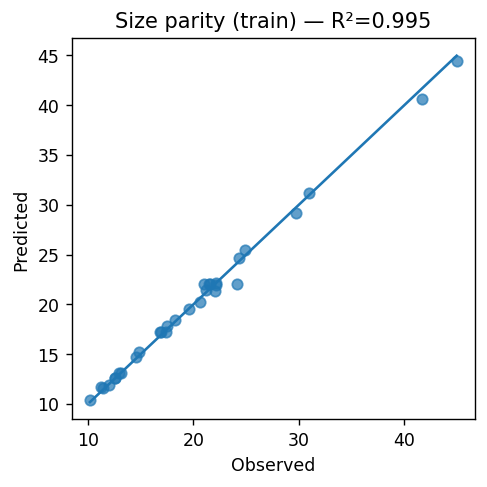

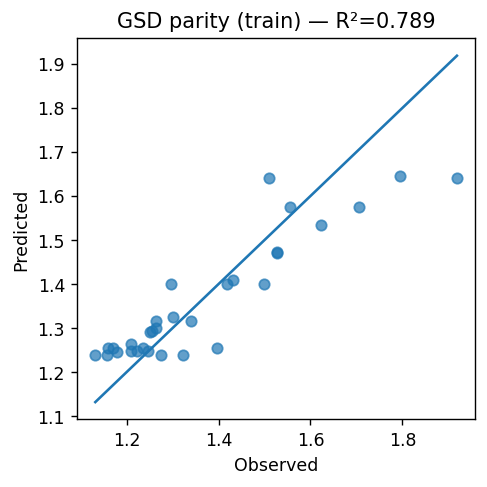

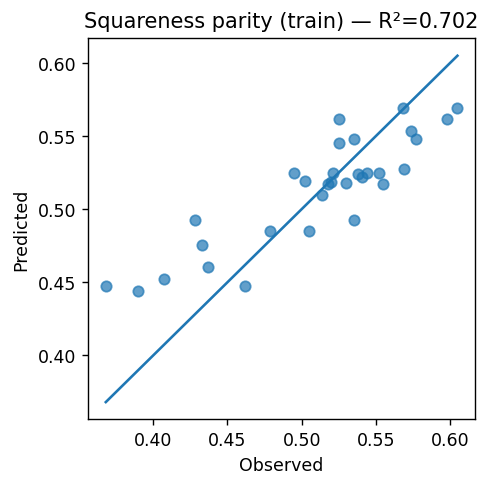

HasProduct train AUC: 0.968
PhasePure train AUC: 0.956
IsCubic train AUC: 0.976


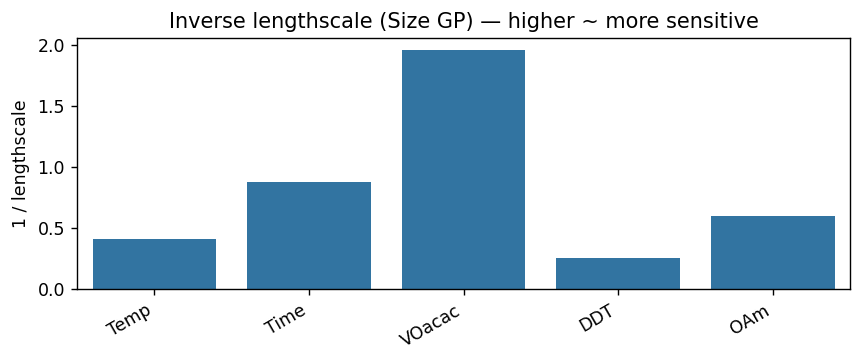

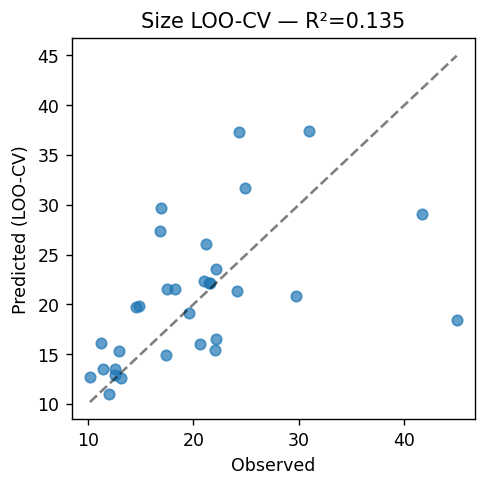

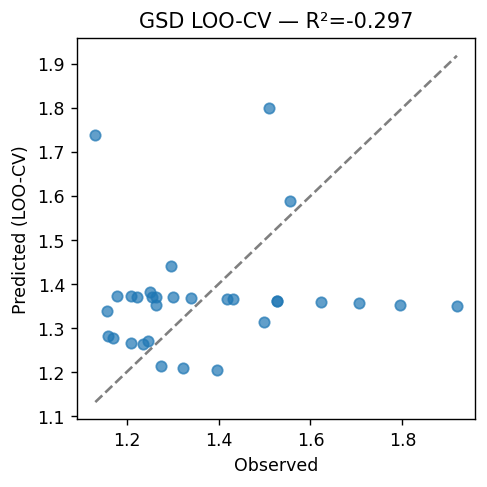

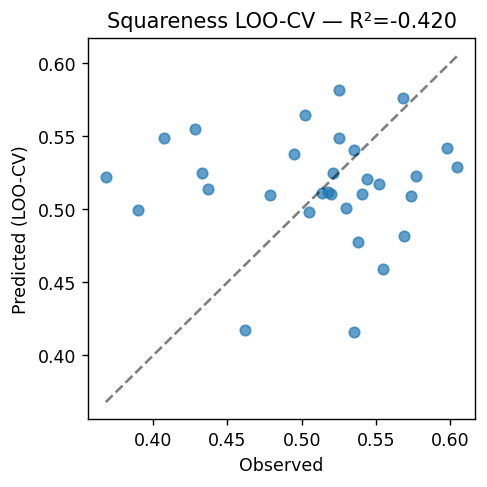

In [198]:
# =========================
# Build optimizer
# =========================
objective_weights = {
    "GSD": 1.5,
    "Squareness": 0.5,
}

bo = TargetedConstrainedBO(
    df=df,
    factor_order=FACTOR_ORDER,
    constraints=constraints,
    objective_weights=objective_weights,
)

viz = BOVisualizer(bo)
viz.plot_all()


## Run a query: “give me the best conditions for this size”

This is the main user-facing function.

If you get “no candidates satisfy constraints”, that’s the model telling you:
- your thresholds are too strict **or**
- your dataset has no feasible evidence for that target region

In that case, loosen `size_tol` or probabilities, or broaden your bounds.



In [202]:
# =========================
# RUN A QUERY (target size -> optimal conditions)
# =========================
target_size_nm = 19     # <-- change this to any size you want (10–30)
size_tol = 2.5            # nm tolerance band for the size constraint

# Probability thresholds (tighten/loosen depending on how conservative you want to be)
p_size_min = 0.30
p_feas_min = 0.30

# Exploration/exploitation control
beta_val = 6.0

# Candidate search settings
candidate_pool = 100000
min_distance = 0.80       # normalized-space diversity threshold

recs = bo.recommend_for_size(
    target_size=target_size_nm,
    size_tol=size_tol,
    p_size_min=p_size_min,
    p_feas_min=p_feas_min,
    candidate_pool=candidate_pool,
    beta_val=beta_val,
    min_distance=min_distance,
    n_return=1,                       # recommend the single best by default
    include_exploration_alt=True,     # plus one exploration alternative
)

display(recs)



,Temp,Time,VOacac,DDT,OAm,target_size,size_tol,Pred_Size,Pred_Size_Std,Pred_GSD,Pred_GSD_Std,Pred_Squareness,Pred_Squareness_Std,P_SizeInBand,P_Feasible,AcqScore
0,306.774375,49.112663,0.300088,2.844371,2.222537,19.0,2.5,20.640484,2.706427,1.339933,0.197451,0.553912,0.050845,0.561575,0.433893,0.976861
1,308.636170,12.986527,0.298120,1.040660,6.504505,19.0,2.5,20.163653,6.319706,1.367623,0.199613,0.549932,0.046581,0.302683,0.391333,0.031193


## Visualization Module

In [200]:
# Parity plots, feasibility AUC, and lengthscale diagnostics
viz.plot_all()

# Acquisition surface - change a and b to any two factors you want to visualize
viz.plot_marginal_surface(
    target_size.0
    a="Temp",
    b="Time",
    size_tol=2.0,
    p_size_min=0.50,
    p_feas_min=0.60,
    beta_val=2.0,
)

viz.plot_marginal_surface(
    target_size=18.0,
    a="Temp",
    b="VOacac",
    size_tol=2.0,
    p_size_min=0.50,
    p_feas_min=0.60,
    beta_val=2.0,
)

viz.plot_marginal_surface(
    target_size=18.0,
    a="VOacac",
    b="Time",
    size_tol=2.0,
    p_size_min=0.50,
    p_feas_min=0.60,
    beta_val=2.0,
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3690921028.py, line 6)

## Optional: sweep sizes (10–30 nm)

This is useful if you want a “lookup table” of optimal conditions across the entire size range.



In [ ]:
# =========================
# SIZE SWEEP (build a table of best conditions across 10–30 nm)
# =========================
sizes = np.linspace(10, 30, 9)  # 10, 12.5, ..., 30

rows = []
for s in sizes:
    try:
        r = bo.recommend_for_size(
            target_size=float(s),
            size_tol=2.5,
            p_size_min=0.30,
            p_feas_min=0.30,
            candidate_pool=50000,
            beta_val=10.0,
            min_distance=0.40,
            n_return=1,
            include_exploration_alt=True
        )
        rows.append(r.iloc[0])
    except Exception as e:
        rows.append(pd.Series({"target_size": s, "error": str(e)}))

sweep = pd.DataFrame(rows)
display(sweep)


,Temp,Time,VOacac,DDT,OAm,target_size,size_tol,Pred_Size,Pred_Size_Std,Pred_GSD,Pred_GSD_Std,Pred_Squareness,Pred_Squareness_Std,P_SizeInBand,P_Feasible,AcqScore
0,276.851982,83.114718,0.095257,4.953222,1.850396,10.0,2.5,12.141125,2.618639,1.367623,0.199613,0.514781,0.056118,0.516334,0.310324,0.444173
0,276.492088,82.277267,0.108008,4.716342,1.894250,12.5,2.5,11.883663,2.728804,1.367623,0.199613,0.512289,0.055817,0.628270,0.323263,0.558327
0,276.473465,88.690839,0.263398,4.520165,3.121604,15.0,2.5,13.808020,3.502413,1.357936,0.198915,0.509413,0.055420,0.499685,0.345026,0.400809
0,277.668979,67.527856,0.336730,4.618430,6.747212,17.5,2.5,17.670888,2.816254,1.367779,0.199613,0.514654,0.054793,0.624421,0.314476,0.465780
0,276.463425,63.678729,0.361084,4.631989,6.521373,20.0,2.5,19.333099,2.836166,1.367622,0.199613,0.510784,0.055481,0.608887,0.309224,0.477327
0,276.002935,56.108191,0.370039,4.550603,5.825126,22.5,2.5,21.359063,2.649481,1.363771,0.199546,0.508945,0.054952,0.611320,0.300371,0.498557
0,277.474520,89.709305,0.639077,4.519238,6.863618,25.0,2.5,25.567227,2.522460,1.367623,0.199613,0.511630,0.056081,0.666230,0.336123,0.639538
0,276.919784,85.860562,0.623772,4.752886,6.854627,27.5,2.5,27.005353,2.844380,1.367622,0.199613,0.511639,0.056608,0.613392,0.321125,0.599878
0,278.669562,89.491470,0.655844,4.982489,6.107872,30.0,2.5,29.609687,2.515226,1.367622,0.199613,0.516846,0.055697,0.673948,0.318314,0.646572


## Optional: iterative BO loop (propose experiments over multiple iterations)

Use this if you want to:
- generate experiment proposals each round
- run them in the lab
- append results back into `df`
- retrain and repeat

**Note:** This notebook can propose, but only you can run the experiments and measure outputs.



In [ ]:
# =========================
# ITERATIVE LOOP (proposals only)
# =========================
# This produces a table of proposed conditions per iteration.
# After you run those experiments and measure outputs, append them to df and rebuild `bo`.

bo_hist = bo.optimize(
    target_size=20.0,
    n_iterations=5,
    size_tol=1.0,
    p_size_min=0.70,
    p_feas_min=0.80,
    candidate_pool=20000,
    beta_start=2.0,
    beta_growth=0.10,
    min_distance=0.40,
    n_candidates=1,
)

display(bo_hist)


RuntimeError: No candidates satisfied constraints. Try increasing size_tol or lowering p_size_min / p_feas_min, or expand bounds.